# Part I: Analysis of Raw Data

Load necessary packages

In [20]:
library(car)
library(MASS)
library(rms)
library(glmnet)
library(leaps)
require(ggplot2)
set.seed(1234)

Read the BodyFat data

In [21]:
fat = read.csv("../data/BodyFat.csv", header = T)

### 1.1 Examine the Bodyfat Data

Use the density plot of `BODYFAT` to find whether there exist abnormal data, and obtain the corresponding `IDNO` of these abnormal observations.

Saving 7 x 7 in image


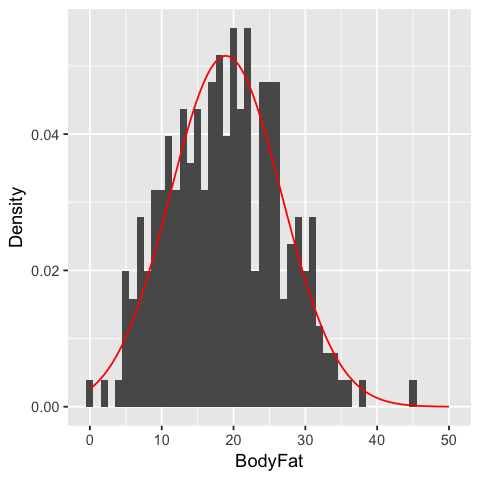

In [71]:
options(repr.plot.width=4, repr.plot.height=4)
x <- seq(0, 50, length.out=500)
df.fat <- with(fat, data.frame(x = x, y = dnorm(x, mean(BODYFAT), sd(BODYFAT))))
ggplot(fat)+
  geom_histogram(aes(x = BODYFAT, y = ..density..),binwidth = 1)+
  xlab("BodyFat")+
  ylab("Density")+
  geom_line(data = df.fat, aes(x = x, y = y), color = "red")
ggsave("../figure/hist_raw_fat.jpeg")

In [30]:
fat[which(fat$BODYFAT==0),]$IDNO

[1] 182

We think that observation with `IDNO` equals to 182 is abnormal point in this data set.

### 1.2 Examine the Relationship Between Density and Bodyfat

According to Folks's experiment result, the relationship between density and bodyfat can be expressed as:

$$\text{Body Fat}\ (100*B)= \frac{495}{\text{Density}\ (gm/cm^3)} - 450$$

Use the knwon relationship between `DENSITY` and `BODYFAT` to detect whether there exist abnormal observations. 

In [31]:
den.inverse = 1/fat$DENSITY
outlier.test.m1 = lm(fat$BODYFAT~den.inverse)
summary(outlier.test.m1)


Call:
lm(formula = fat$BODYFAT ~ den.inverse)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0510 -0.1612 -0.0480  0.0700 15.3135 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -405.786      3.994  -101.6   <2e-16 ***
den.inverse  448.183      4.214   106.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.142 on 250 degrees of freedom
Multiple R-squared:  0.9784,	Adjusted R-squared:  0.9783 
F-statistic: 1.131e+04 on 1 and 250 DF,  p-value: < 2.2e-16


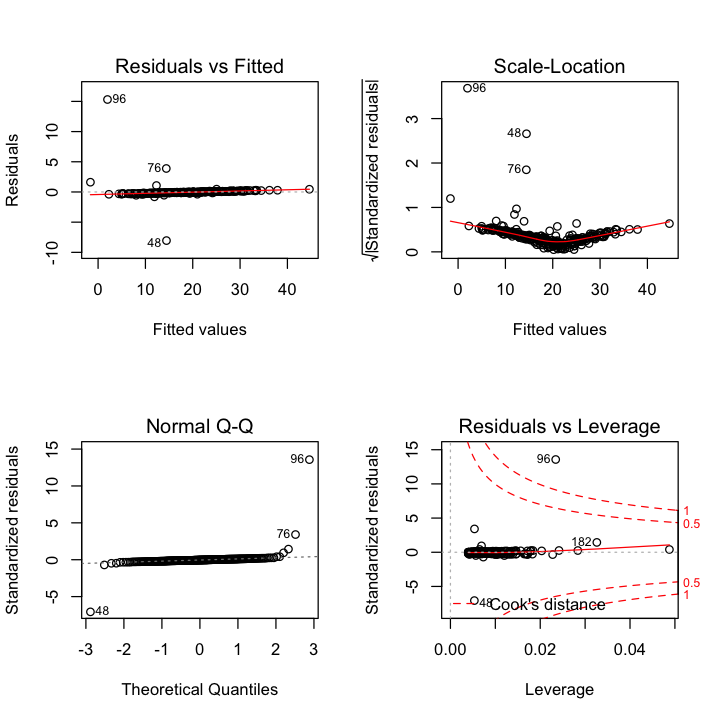

In [32]:
options(repr.plot.width=6, repr.plot.height=6)
par(mfcol=c(2,2))
plot(outlier.test.m1)

Warning message:
“Ignoring unknown aesthetics: label”Saving 7 x 7 in image


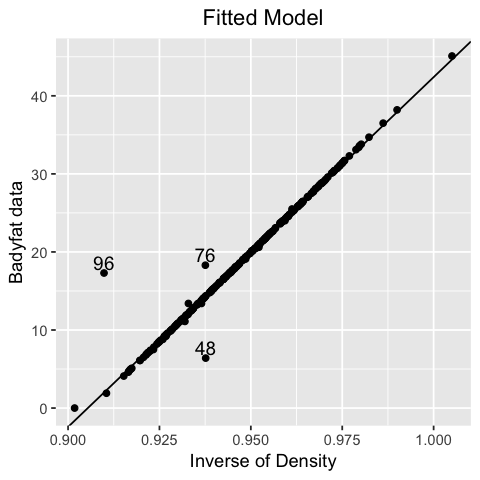

In [72]:
options(repr.plot.width=4, repr.plot.height=4)
ggplot()+
  geom_point(aes(x=den.inverse,y=fat$BODYFAT,label=fat$IDNO))+
  geom_abline(slope = outlier.test.m1$coefficients[2],intercept = outlier.test.m1$coefficients[1])+
  geom_text(aes(x=den.inverse[c(48,76,96)],y=fat$BODYFAT[c(48,76,96)],
                label=fat$IDNO[c(48,76,96)]),size = 4,vjust = 0, nudge_y = 0.5)+
  xlab("Inverse of Density")+
  ylab("Badyfat data")+
  ggtitle("Fitted Model")+
  theme(plot.title = element_text(hjust = 0.5))
ggsave("../figure/fitted_density_model.jpeg")

According to the result shown above, we think observations with `IDNO` equals to 48,76,96 are the outliers. Though we know the relationship between badyfat and density, we cannot detect either the density nor bodyfat are abnormal in their values, therefore we chooes to delete them in our data set.

### 1.3 Examine the Relationship Between Weight, Height, and Adiposity

The relationship between Weight, Height, and Adiposity can be expressed by:

$$\text{Body Adiposity Index} = \frac{703*\text{Weight in kg}}{(\text{Height in m})^{2}} $$

We use these relationship to detect whether there exist abnormal observations in our data set.

In [36]:
bmi=fat$WEIGHT/(fat$HEIGHT^2)
outlier.test.m2 = lm(fat$ADIPOSITY~bmi)
summary(outlier.test.m2)


Call:
lm(formula = fat$ADIPOSITY ~ bmi)

Residuals:
    Min      1Q  Median      3Q     Max 
-19.595  -1.844  -0.235   1.633  19.507 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  20.9685     0.5954  35.218  < 2e-16 ***
bmi         121.0993    15.1445   7.996 4.77e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.262 on 250 degrees of freedom
Multiple R-squared:  0.2037,	Adjusted R-squared:  0.2005 
F-statistic: 63.94 on 1 and 250 DF,  p-value: 4.767e-14


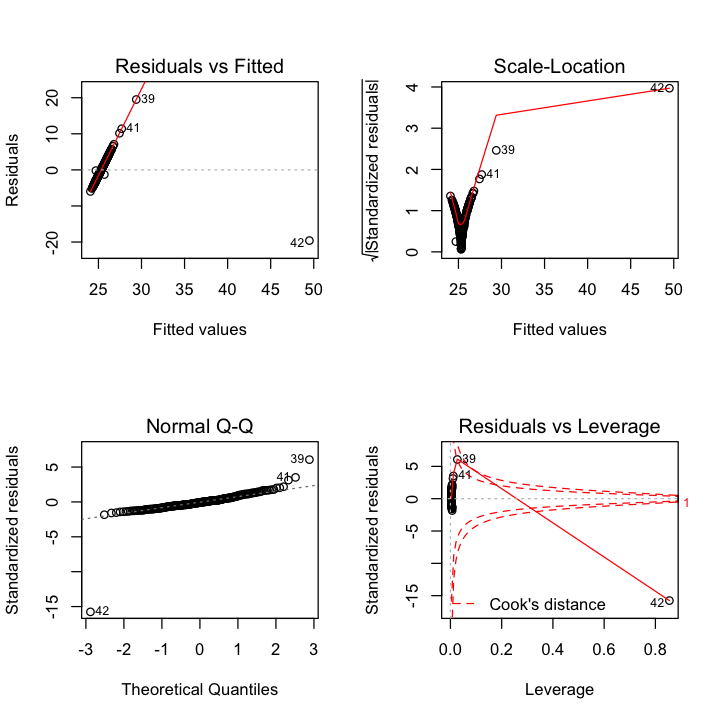

In [37]:
options(repr.plot.width=6, repr.plot.height=6)
par(mfcol=c(2,2))
plot(outlier.test.m2)

Warning message:
“Ignoring unknown aesthetics: label”Saving 7 x 7 in image


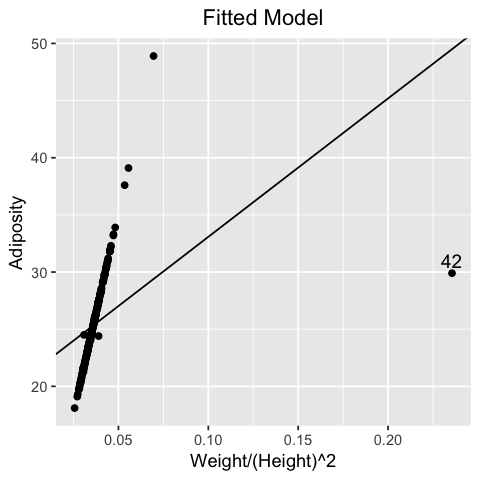

In [76]:
options(repr.plot.width=4, repr.plot.height=4)
ggplot()+
  geom_point(aes(x=bmi,y=fat$ADIPOSITY,label=fat$IDNO))+
  geom_abline(slope = outlier.test.m2$coefficients[2],intercept = outlier.test.m2$coefficients[1])+
  geom_text(aes(x=bmi[c(42)],y=fat$ADIPOSITY[c(42)],
                label=fat$IDNO[c(42)]),size = 4,vjust = 0, nudge_y = 0.5)+
  xlab("Weight/(Height)^2")+
  ylab("Adiposity")+
  ggtitle("Fitted Model")+
  theme(plot.title = element_text(hjust = 0.5))
ggsave("../figure/fitted_raw_wh_model.jpeg")

According to above linear regression line, we think that observation with `IDNO=42` has great influence in the whole model, therefore we fit the same model again without point 42.

Besides, we also examine the point 42 and find that the height in this observation is abnormal, we want to use the new model to replace the height.

In [40]:
outlier.test.m3 = lm(fat$ADIPOSITY[-42]~bmi[-42])
summary(outlier.test.m3)


Call:
lm(formula = fat$ADIPOSITY[-42] ~ bmi[-42])

Residuals:
     Min       1Q   Median       3Q      Max 
-3.02751 -0.02632  0.00396  0.02963  2.76506 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.1942     0.1174   1.654   0.0994 .  
bmi[-42]    698.6151     3.2188 217.042   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2648 on 249 degrees of freedom
Multiple R-squared:  0.9947,	Adjusted R-squared:  0.9947 
F-statistic: 4.711e+04 on 1 and 249 DF,  p-value: < 2.2e-16


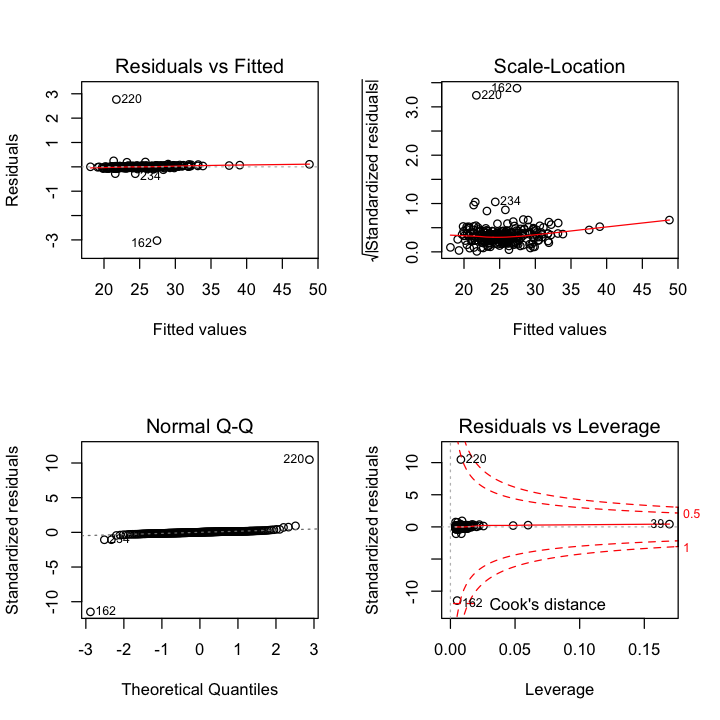

In [41]:
options(repr.plot.width=6, repr.plot.height=6)
par(mfcol=c(2,2))
plot(outlier.test.m3)

Warning message:
“Ignoring unknown aesthetics: label”Saving 7 x 7 in image


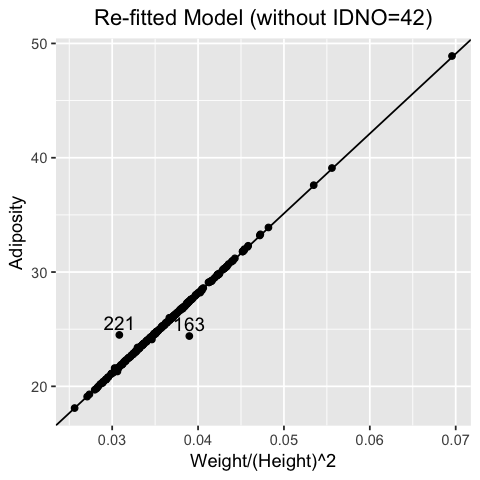

In [75]:
ggplot()+
  geom_point(aes(x=bmi[-42],y=fat$ADIPOSITY[-42],label=fat$IDNO[-42]))+
  geom_abline(slope = outlier.test.m3$coefficients[2],intercept = outlier.test.m3$coefficients[1])+
  geom_text(aes(x=bmi[c(221,163)],y=fat$ADIPOSITY[c(221,163)],
                label=fat$IDNO[c(221,163)]),size = 4,vjust = 0, nudge_y = 0.5)+
  xlab("Weight/(Height)^2")+
  ylab("Adiposity")+
  ggtitle("Re-fitted Model (without IDNO=42)")+
  theme(plot.title = element_text(hjust = 0.5))
ggsave("../figure/refitted_wh_model.jpeg")

In [45]:
fat$HEIGHT[42] = sqrt(outlier.test.m3$coefficients[2]*(fat$WEIGHT[42])/(fat$ADIPOSITY[42]-outlier.test.m3$coefficients[1]))

According to the result shown above, we think observations with `IDNO=163,221` are the outliers.

We change the height value of `IDNO=42` and remove the `IDNO=163,221` points.

### 1.4 Detect other outliers

Remove the outliers we found before and use multiple linear regression to fit the full model with remained observations.

In [60]:
# fit the full model
fat.rm = fat[-c(182,76,96,48,221,163),]
fat.rm$DENSITY = NULL
fat.rm$IDNO = NULL
write.csv(fat.rm,"../data/clean_fat.csv",row.names=FALSE)

In [61]:
library(corrplot)
library(RColorBrewer)

In [91]:
jpeg('../figure/correlation.jpeg')
par(mfrow=c(1,1))
corrplot(corr,order = "hclust",addrect = 10,
         col = brewer.pal(n = 8, name = "RdYlBu"),tl.col = "black",tl.cex = 0.6)
dev.off()

pdf 
  2

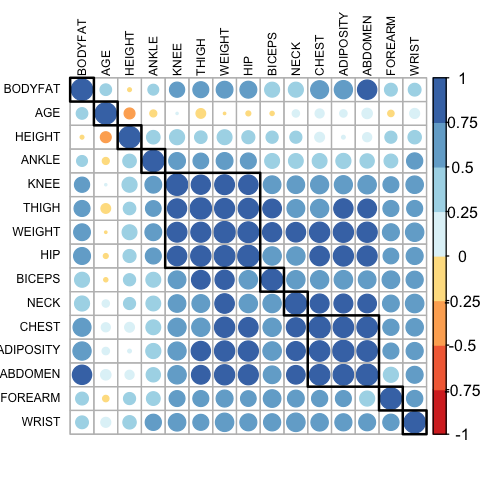

In [92]:
corrplot(corr,order = "hclust",addrect = 10,
         col = brewer.pal(n = 8, name = "RdYlBu"),tl.col = "black",tl.cex = 0.6)

After removing outliers found before, we examine the correlation between features via `corrplot`. Those features within the same box are shown high correlation with each other. We may reconsider these multicollinearity in our future variable selection.

<img style="float: left;" src="../figure/box_feature_plot.jpeg" width="80%">

From boxplots of each feature, we find there exist certain within-feature outliers and found that observations with `IDNO=39` accounts for a large part of these abnormal values. Consider that this person may truly exist due to its large body size, we choose to keep this observations.

### 1.5 Fit the full model with clean data

In [66]:
test.rmoutlier.first = lm(BODYFAT~.,fat.rm)
summary(test.rmoutlier.first)


Call:
lm(formula = BODYFAT ~ ., data = fat.rm)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.7520 -2.6658 -0.2518  2.8721  9.0296 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -128.51865   48.43620  -2.653  0.00852 ** 
AGE            0.05634    0.02968   1.898  0.05890 .  
WEIGHT        -0.39756    0.13378  -2.972  0.00327 ** 
HEIGHT         1.57728    0.69184   2.280  0.02353 *  
ADIPOSITY      2.29566    0.99186   2.315  0.02152 *  
NECK          -0.37040    0.21667  -1.709  0.08870 .  
CHEST         -0.06717    0.09880  -0.680  0.49726    
ABDOMEN        0.88394    0.08561  10.325  < 2e-16 ***
HIP           -0.23436    0.13661  -1.716  0.08758 .  
THIGH          0.24869    0.13502   1.842  0.06678 .  
KNEE           0.04553    0.22935   0.198  0.84283    
ANKLE          0.16054    0.20756   0.773  0.44004    
BICEPS         0.18423    0.15853   1.162  0.24638    
FOREARM        0.37543    0.18465   2.033  0.04318 *  
WRIST         -1.5

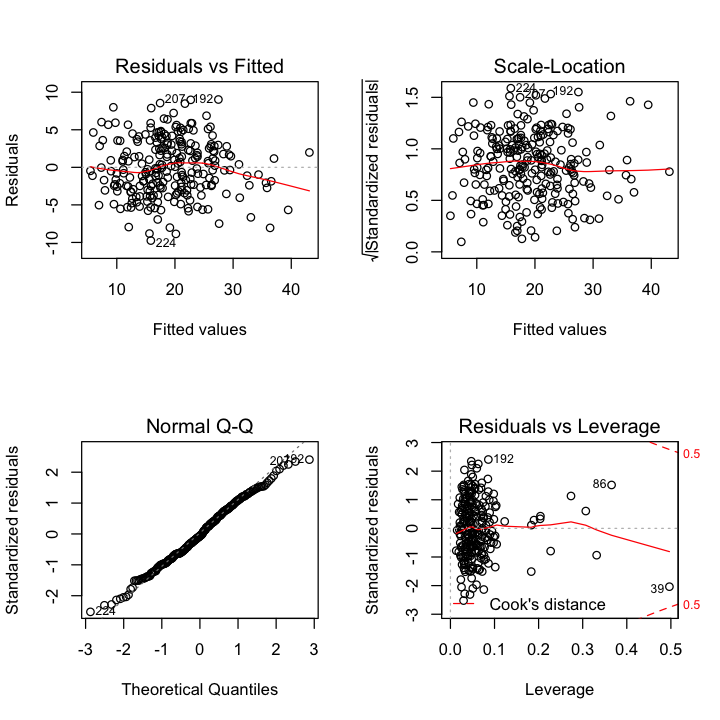

In [67]:
options(repr.plot.width=6, repr.plot.height=6)
par(mfcol=c(2,2))
plot(test.rmoutlier.first)

### 1.6 Examine Normality of the Response Variable

First we draw the Normal Q-Q plot of our full model.

Saving 7 x 7 in image


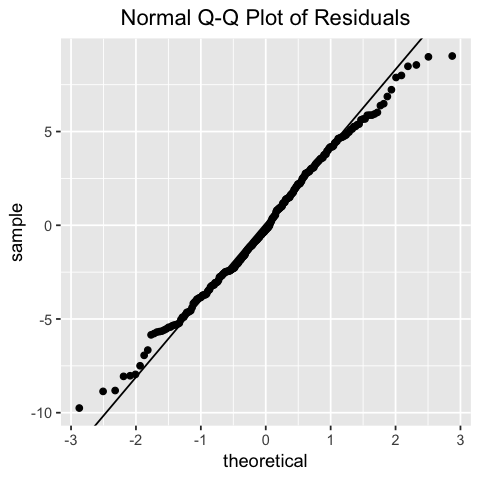

In [83]:
normal.qq.plot <- function(residual)
{
  y <- quantile(residual[!is.na(residual)], c(0.25, 0.75))
  x <- qnorm(c(0.25, 0.75))
  slope <- diff(y)/diff(x)
  int <- y[1L] - slope * x[1L]
  d <- data.frame(res = residual)
  ggplot(d, aes(sample = res))+
    stat_qq()+
    geom_abline(slope = slope, intercept = int)+
    ggtitle("Normal Q-Q Plot of Residuals")+
    theme(plot.title = element_text(hjust = 0.5))
}
options(repr.plot.width=4, repr.plot.height=4)
normal.qq.plot(test.rmoutlier.first$residuals)
ggsave("../figure/res_qq_plot.jpeg")

In [84]:
shapiro.test(fat.rm$BODYFAT)


	Shapiro-Wilk normality test

data:  fat.rm$BODYFAT
W = 0.99044, p-value = 0.1062


From the normal QQ plot and the result of shapiro.test above, we roughly think the residuals are normal distribution. Then, we conduct box-cox transformation on our full model to find out whether we need transform our data set.

pdf 
  2

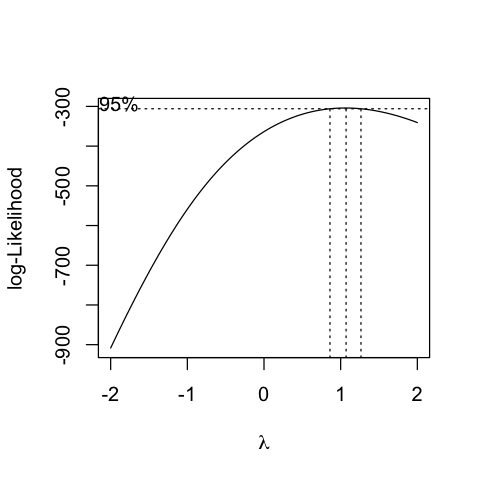

In [87]:
jpeg("../figure/boxcox.jpeg")
options(repr.plot.width=4, repr.plot.height=4)
par(mfrow=c(1,1))
boxcox(test.rmoutlier.first)
dev.off()
boxcox(test.rmoutlier.first)

From the above result, the $\lambda$ almost equals to 1, therefore we do not transform our data.